In [1]:
import pandas as pd          # for extracting and manipulating data from dataset
import numpy as np           # for mathematical calculations
import matplotlib.pyplot as plt    # for plotting graphs
from datetime import datetime      # to access datetime
from sklearn.metrics import mean_squared_error
%matplotlib inline
import warnings                    #  to ignore warnings
warnings.filterwarnings("ignore")


In [2]:
train = pd.read_csv ('/content/Train data.csv')
test = pd.read_csv('/content/Test data.csv')


In [3]:
#We make a copy of the data so that we do not lose the original data even after changes
train_original = train.copy()
test_original = test.copy()

In [4]:
# diving deeper in dataset
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [5]:
train.shape, test.shape

((18288, 3), (5112, 2))

In [6]:
print(train.dtypes, test.dtypes)      # data tyoes of each feature

train.head()   #first 5 rows of data

ID           int64
Datetime    object
Count        int64
dtype: object ID           int64
Datetime    object
dtype: object


,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


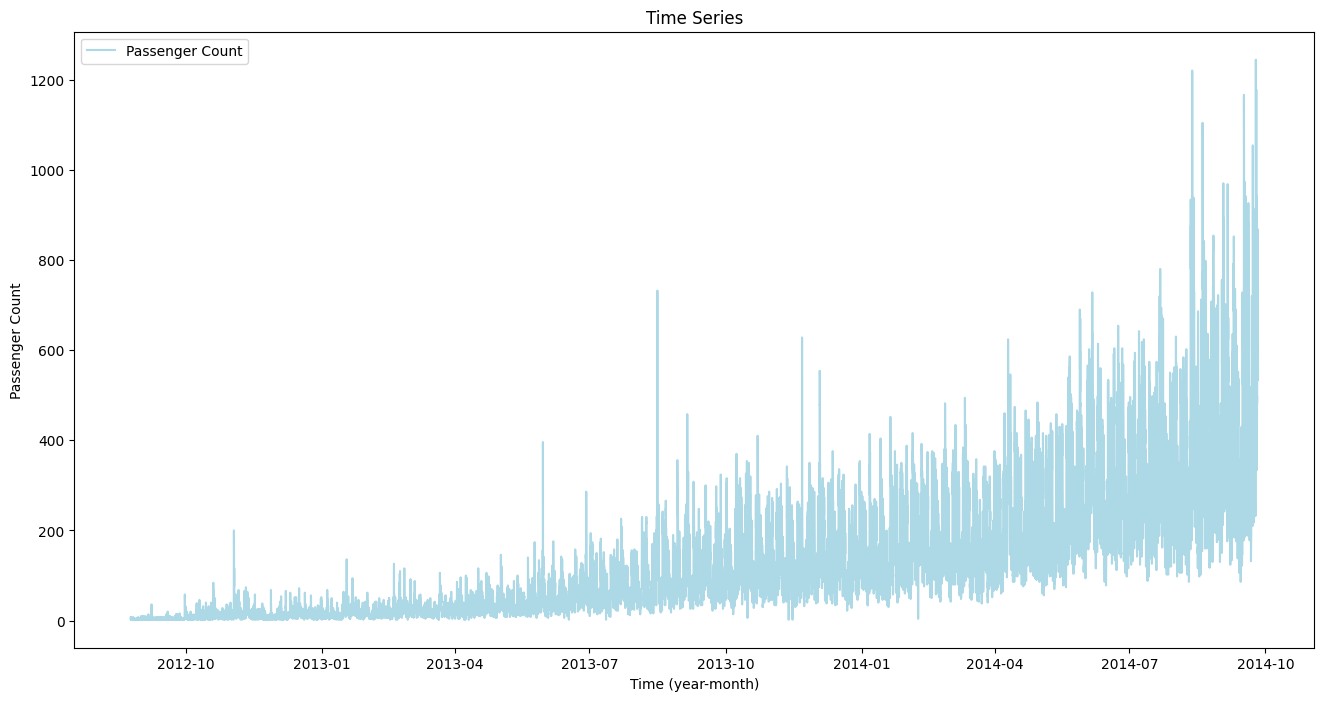

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Changing the object of Datetime in train and test data to 'datetime' to extract features from it
train['Datetime'] = pd.to_datetime(train['Datetime'], format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test['Datetime'], format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original['Datetime'], format='%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original['Datetime'], format='%d-%m-%Y %H:%M')

# To extract the year, month, day, and hour for further analysis
for i in (train, test, train_original, test_original):
    i['year'] = i['Datetime'].dt.year
    i['month'] = i['Datetime'].dt.month
    i['day'] = i['Datetime'].dt.day
    i['Hour'] = i['Datetime'].dt.hour

# To generate weekend and weekday variables
train['day of week'] = train['Datetime'].dt.dayofweek  # Removed space in 'day of week '

# We assign 1 if the day of the week is a weekend (Saturday or Sunday) and 0 if it is a weekday
# We assign 1 if the day of the week is a weekend (Saturday or Sunday) and 0 if it is a weekday
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

train['weekend'] = train['Datetime'].apply(applyer)



# Assigning index as Datetime to get the time period on the x-axis
train.index = train['Datetime']
df = train.drop('ID', axis=1)  # Corrected the syntax for dropping a column
ts = df['Count']  # Corrected to reference df where 'ID' is dropped

# Plotting
plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count', color='lightblue')  # Set plot color to light blue
plt.title('Time Series')
plt.xlabel('Time (year-month)')
plt.ylabel('Passenger Count')
plt.legend(loc='best')
plt.show()  # Added to explicitly show the plot in some environments


<Axes: xlabel='year'>

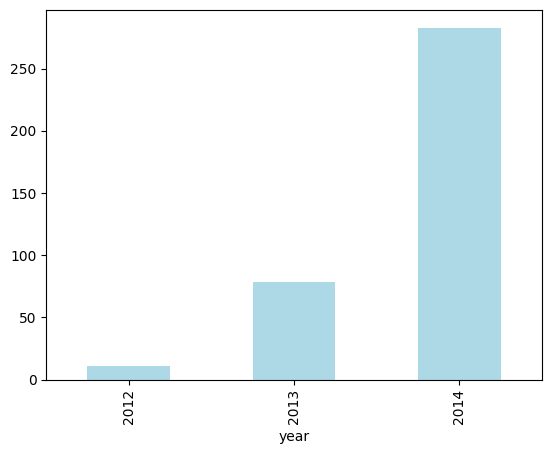

In [13]:
#General trend is increase in passenger count with increase in time. Next we do EXPLORATORY ANALYSIS

#To check yearly passenger count
train.groupby('year')['Count'].mean().plot.bar(color='lightblue')

<Axes: xlabel='month'>

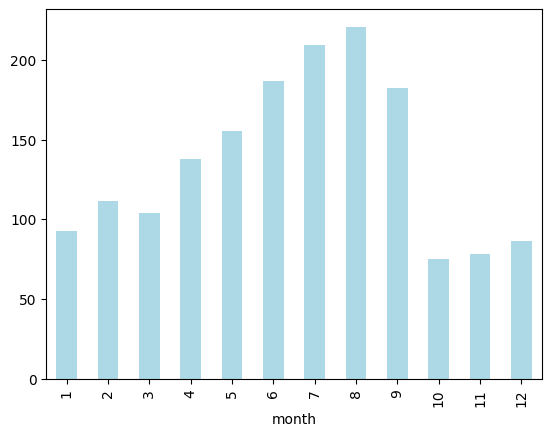

In [14]:
# Passenger count increase exponentially with increase in years. Let's check for months.

train.groupby('month')['Count'].mean().plot.bar(color='lightblue')

<Axes: title={'center': 'Passenger Count(Monthwise)'}, xlabel='year,month'>

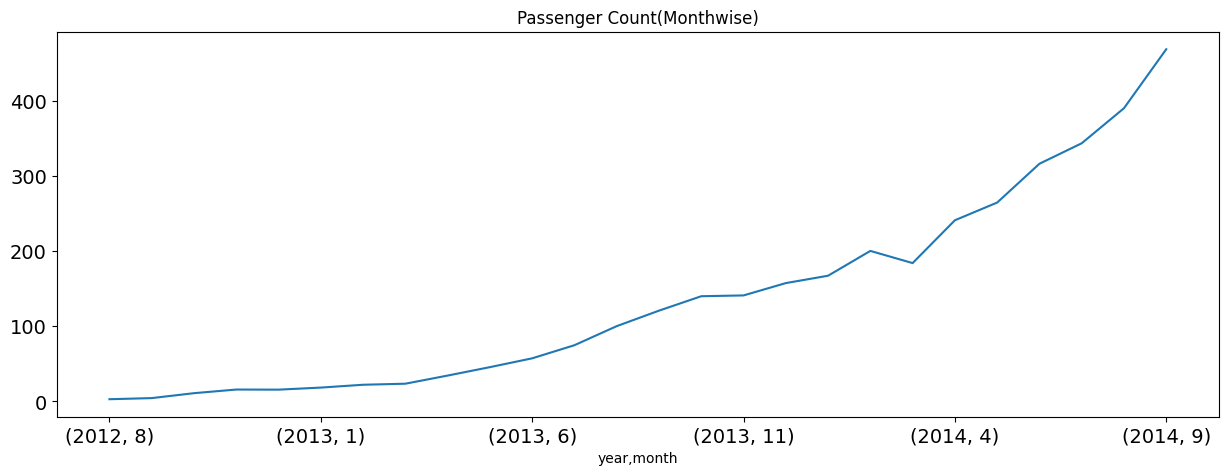

In [15]:
# we see a monthly decrease in the mean of passenger count in last three months
temp  = train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize = (15,5), title = 'Passenger Count(Monthwise)', fontsize = 14)

<Axes: xlabel='day'>

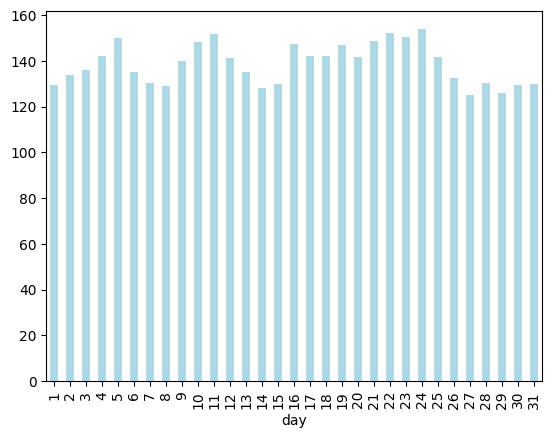

In [16]:
#Year 2014 does not has last three months that is the reason we are getting less counts for these months
train.groupby('day')['Count'].mean().plot.bar(color='lightblue')

<Axes: xlabel='Hour'>

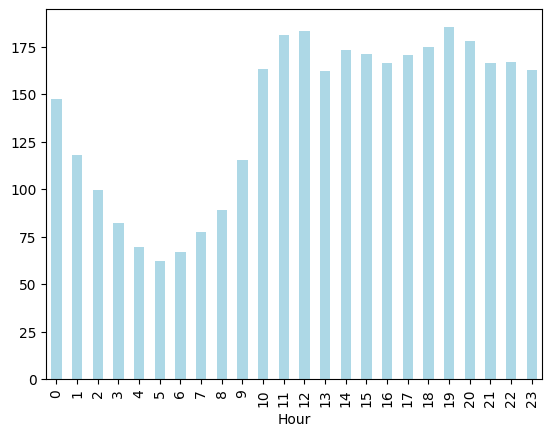

In [17]:
#not much insights available from day wise counts. Let's check the mean of hourly passenger count
train.groupby('Hour')['Count'].mean().plot.bar(color='lightblue')

<Axes: xlabel='weekend'>

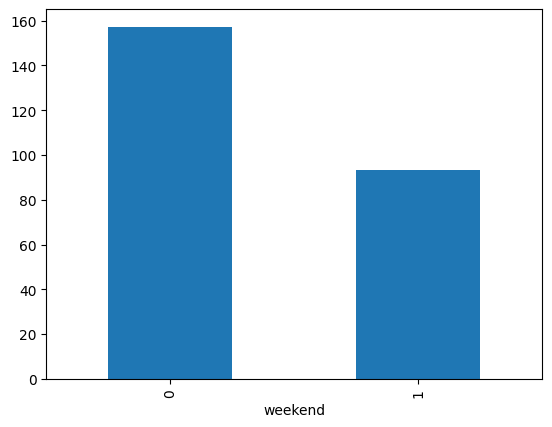

In [18]:
#Peak traffic os at 7 pm and then it decreases till 5 am. Let's check the traffic trend for weekends.
train.groupby('weekend')['Count'].mean().plot.bar()

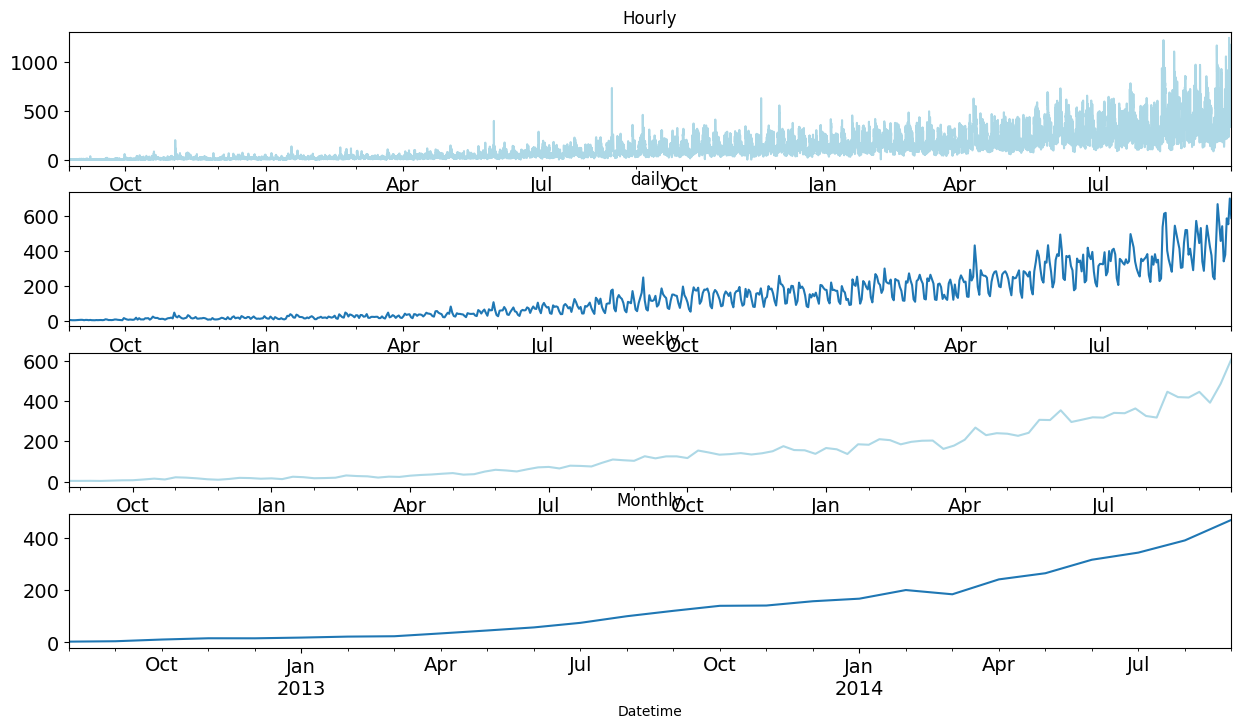

In [21]:
#Clearly traffic is more on weekdays than weekends.
# Before oving forward to modelling we have to drop the ID variable as it has got nothing to do with passenger count


# We aggregate hourly time series to daily, weekly and monthly to reduce the noise and make it more stable for model to learn
hourly = train.resample('H').mean()
daily = train.resample('D').mean()
weekly = train.resample('W').mean()
monthly = train.resample('M').mean()

fig,ax = plt.subplots(4,1)
hourly.Count.plot(figsize= (15,8), title = 'Hourly', fontsize= 14, ax = ax[0], color='lightblue')
daily.Count.plot(figsize=(15,8), title = 'daily', fontsize= 14, ax=ax [1])
weekly.Count.plot(figsize=(15,8), title = 'weekly', fontsize = 14, ax = ax [2],color='lightblue')
monthly.Count.plot(figsize=(15,8), title = 'Monthly', fontsize= 14, ax = ax [3])

plt.show()

In [22]:
# We can see that the time series is becoming more and more stable. So we will work with the daily time series

test.Timestamp = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')
test.index = test.Timestamp
test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index = train.Timestamp
train = train.resample('D').mean()

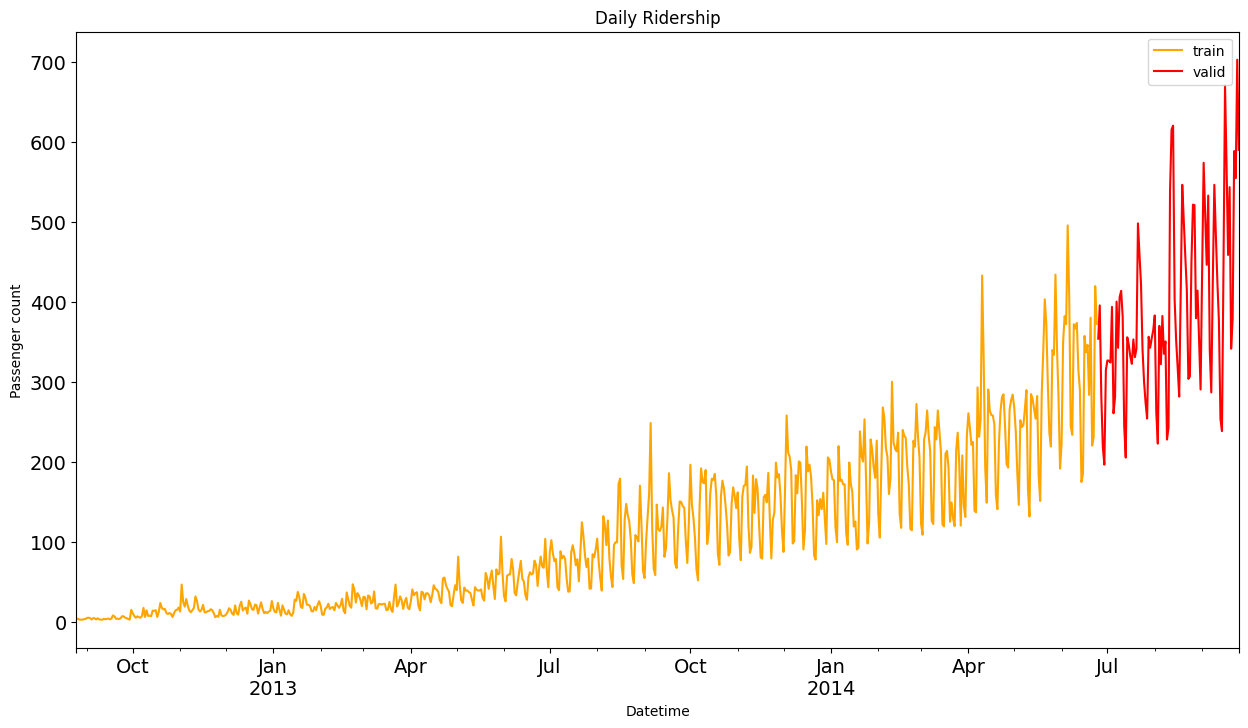

In [27]:

# Splitting the data into training and validation. We take the last 3 months as our validation data and the rest as training data.

Train = train.loc['2012-08-25':'2014-06-24']
valid = train.loc['2014-06-25':'2014-09-25']

Train['Count'].plot(label='train',color='orange')
valid['Count'].plot(figsize=(15, 8), title='Daily Ridership', fontsize=14, label='valid', color='red')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='upper right')
plt.show()


Text(0.5, 1.0, 'Naive Forecast')

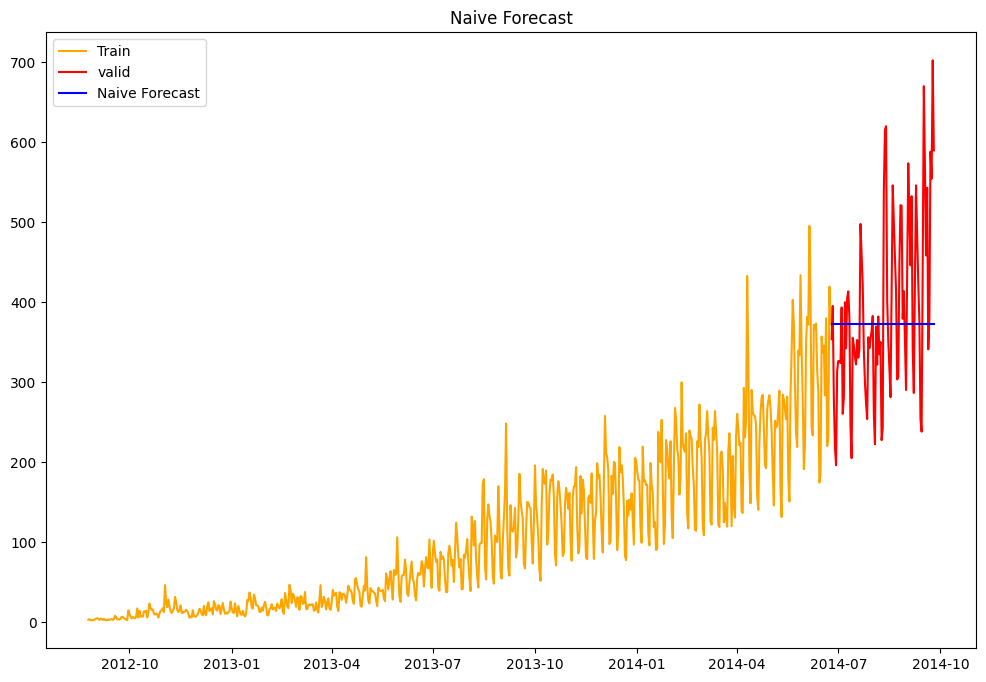

In [29]:
dd = np.asarray(Train.Count)        # to convert the train to array
y_hat = valid.copy()                # copy of validation set
y_hat['naive'] = dd[len(dd)-1]      # new column for naive forecasted values all equal to the last value of train data
plt.figure (figsize=(12,8))
plt.plot(Train.index, Train['Count'], label = 'Train', color='orange')
plt.plot(valid.index, valid['Count'], label = 'valid', color='red')
plt.plot(y_hat.index, y_hat['naive'], label = 'Naive Forecast',color='blue')
plt.legend (loc= 'best')
plt.title('Naive Forecast')

In [30]:
from math import sqrt
rms= sqrt(mean_squared_error(valid.Count, y_hat.naive))
print (rms)

111.79050467496724


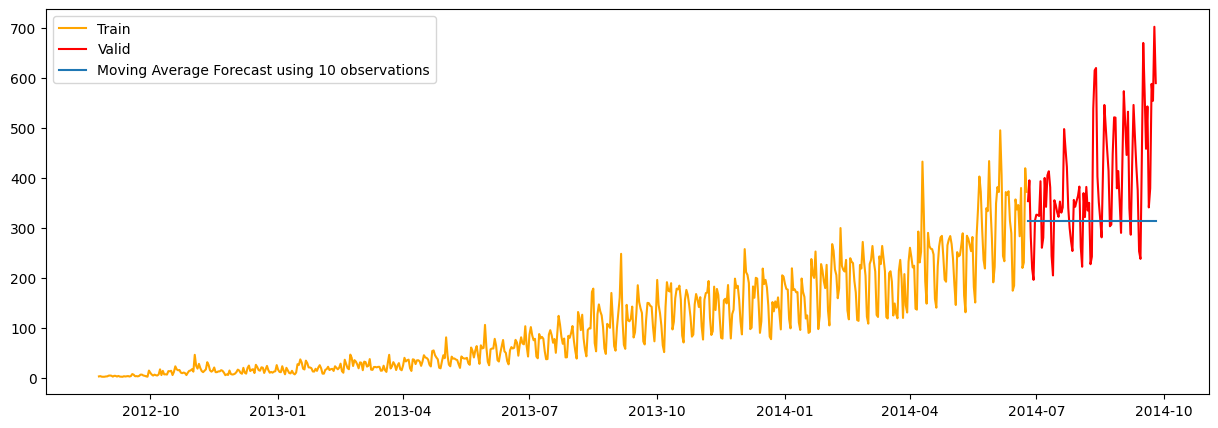

RMSE=  134.23733308950264


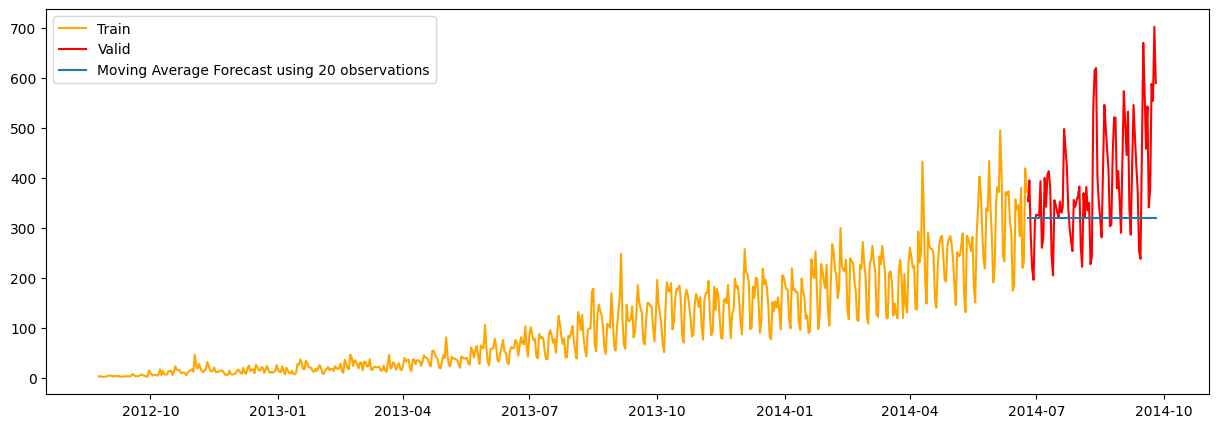

RMSE=  130.4498497755042


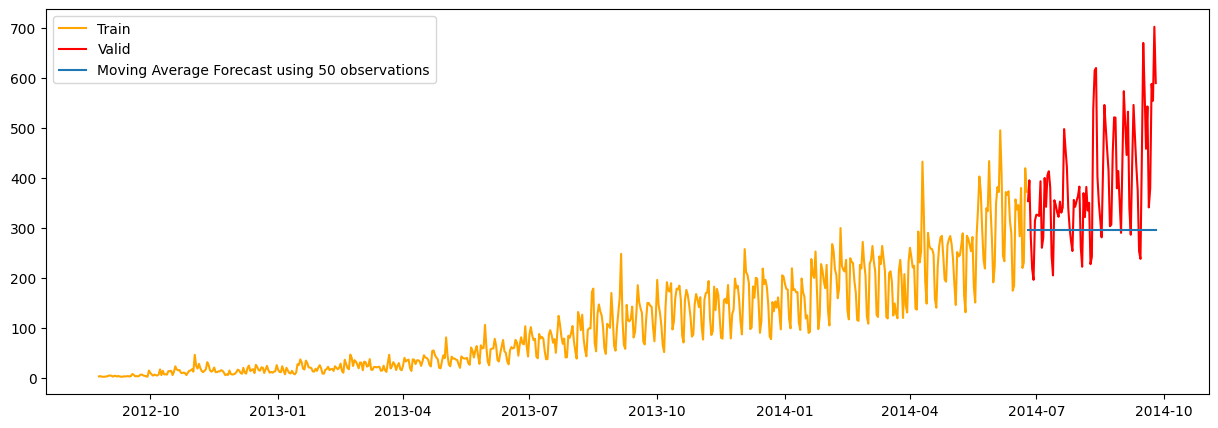

RMSE=  144.19175679986793


In [32]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations.
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train', color='orange')
plt.plot(valid['Count'], label='Valid', color='red')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations')
plt.legend(loc='best')
plt.show()
print('RMSE= ',sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)))
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations.
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train', color='orange')
plt.plot(valid['Count'], label='Valid', color='red')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations')
plt.legend(loc='best')
plt.show()
print('RMSE= ',sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)))
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations.
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train',color='orange')
plt.plot(valid['Count'], label='Valid',color='red')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations')
plt.legend(loc='best')
plt.show()
print('RMSE= ',sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)))